In [65]:
pd.set_option('display.max_colwidth', 100)
from copy import deepcopy
from scipy.stats.mstats import mquantiles
from chase.base import *
from chase.utils import *
from chase.fit import *
from chase.cpt import w_prelec
import itertools

FIGDEST = '/Users/markant/code/chase/chase/paper/results_figures'
TABDEST = '/Users/markant/code/chase/chase/paper/results_tables'
outdir = lambda sim_id: 'results_fits/chase_fitresults_%s' % (sim_id)

# number of iterations for each parameter set
N_ITER = 1

# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., 5, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],
        'sc': [0, 20, 1],
        'p_stop': [0, 1, .5],
        'k': [0, 5, 1],
        'sep': [0, 10, 1]}

PARSETS = {}
PARSETS['optional'] = [['theta', 'tau', 'k', 'sep'],
                       #['theta', 'p_stay', 'tau'],
                       ['theta', 'tau', 'prelec_gamma', 'k', 'sep'],
                       #['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                       #['theta', 'p_stay', 'tau', 'pow_gain'],
                       #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                       ]

PARSETS['geometric'] = [['p_stop', 'p_stay', 'tau'],
                        ['p_stop', 'p_stay', 'tau', 'prelec_gamma'],
                        #['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                        ['p_stop', 'p_stay', 'tau', 'pow_gain'],
                        #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                        ]

FIXED = {}
for pref_units in ['sums', 'diffs']:
    FIXED[('optional',pref_units)] = {'p_sample_H': 0.5,
                                      'minsamplesize': 2,
                                      'sc': .5,
                                      'pref_units': pref_units,
                                      'stoprule': 'optional',
                                      'max_T': 100}

    FIXED[('geometric',pref_units)] = {'p_sample_H': 0.5,
                                       'minsamplesize': 2,
                                       'pref_units': pref_units,
                                       'stoprule': 'geometric',
                                       'theta': 30}
    
cp = {}
bf_cp = {}
bf_par = {}
msd_cp = {}
quant = {}
bf_quant = {}

# load the six problems
arr = np.genfromtxt('data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}

In [48]:
data = pd.read_csv('data/hertwig2004/hertwig2004_data.csv', index_col=0)

In [49]:
data.groupby('problem').apply(lambda d: d[d.choice==1].samplesize.mean() - d[d.choice==0].samplesize.mean())

problem
0    -7.469697
1     6.129870
2   -10.857143
3    -7.298701
4     6.600000
5    -2.257576
dtype: float64

In [50]:
data = pd.read_csv('data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==1]

In [51]:
data.groupby('problem').apply(lambda d: d[d.choice==1].samplesize.mean() - d[d.choice==0].samplesize.mean())

problem
0    -4.394410
1     6.145658
2    -7.537879
3   -10.140056
4     3.892157
5    -8.025078
dtype: float64

In [52]:
data = pd.read_csv('data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==2]
data.groupby('problem').apply(lambda d: d[d.choice==1].samplesize.mean() - d[d.choice==0].samplesize.mean())

problem
0     0.604278
1    -1.839474
2    -9.757143
3   -20.305714
4    -7.334286
5    -2.357143
dtype: float64

# Fit

In [63]:
SIM_ID = 'hertwig2004_amp'
OUTDIR  = outdir(SIM_ID)
data = pd.read_csv('data/hertwig2004/hertwig2004_data.csv', index_col=0)

In [46]:
SIM_ID = 'hau_exp1_amp'
OUTDIR  = outdir(SIM_ID)
data = pd.read_csv('data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==1]

In [54]:
SIM_ID = 'hau_exp2_amp'
OUTDIR  = outdir(SIM_ID)
data = pd.read_csv('data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==2]

In [66]:
#for stoprule, pref_units in itertools.product(['optional', 'geometric'], ['diffs', 'sums']):
for stoprule, pref_units in itertools.product(['optional'], ['diffs']):    
    print '[%s, %s]\nsaving results to %s' % (stoprule, pref_units, OUTDIR)
    P = PARSETS[stoprule]
    F = FIXED[(stoprule,pref_units)]
    
    if stoprule == 'optional':      model = CHASEModel
    elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
        
    for parset in P:

        fitting = {p: PARS[p] for p in parset}

        m = model(drift='cpt',
                  startdist='laplace',
                  problems=problems,
                  stoprule=stoprule)

        # fit
        results = fit_mlh(m, problems, data, SIM_ID, F, fitting, 
                          niter=N_ITER, outdir=OUTDIR)

        print results.sort('nllh')

[optional, diffs]
saving results to results_fits/chase_fitresults_hertwig2004_amp
hertwig2004_amp(k,sep,tau,theta|max_T=100,minsamplesize=2,p_sample_H=0.5,pref_units=diffs,sc=0.5,stoprule=optional)
0/5
['theta']: [ 1.]
iteration           0
success          True
nllh          703.561
k            0.653994
N                 150
bic           1427.16
theta               1
k            0.653994
sep           6.27782
tau               NaN
Name: 0, dtype: object
hertwig2004_amp(k,sep,tau,theta|max_T=100,minsamplesize=2,p_sample_H=0.5,pref_units=diffs,sc=0.5,stoprule=optional)
1/5
['theta']: [ 2.]
iteration           0
success          True
nllh          681.834
k            0.606654
N                 150
bic           1383.71
theta               2
k            0.606654
sep           4.35909
tau          0.302796
Name: 1, dtype: object
hertwig2004_amp(k,sep,tau,theta|max_T=100,minsamplesize=2,p_sample_H=0.5,pref_units=diffs,sc=0.5,stoprule=optional)
2/5
['theta']: [ 3.]
iteration          0


/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [191]:
# create a table summarizing the best-fitting result for each parameter
# combination
allresults = pd.DataFrame(columns=['sim_id', 'stoprule', 'pref_units', 'k', 'N', 'nllh', 'bic'])

for stoprule, pref_units in itertools.product(['optional', 'geometric'], ['diffs', 'sums']):
    
    P = PARSETS[stoprule]
    F = FIXED[(stoprule,pref_units)]
            
    for parset in P:
        fitting = {p: PARS[p] for p in parset}
        b = best_result(SIM_ID, F, fitting, outdir=OUTDIR, nopars=True)
        b['stoprule'] = stoprule
        b['pref_units'] = pref_units
        allresults.loc[allresults.shape[0]] = b

allresults.sort_values(by='bic', inplace=True)
allresults.to_csv('%s/%s_fitsummary.csv' % (TABDEST, SIM_ID))

In [65]:
allresults = pd.read_csv('%s/%s_fitsummary.csv' % (TABDEST, SIM_ID), index_col=0)
allresults

,sim_id,stoprule,pref_units,k,N,nllh,bic
3,"hau_exp1(p_stay,pow_gain,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=opti...",optional,diffs,4.0,230.0,943.430803,1908.613923
7,"hau_exp1(p_stay,pow_gain,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=sums,stoprule=optio...",optional,sums,4.0,230.0,943.613630,1908.979577
5,"hau_exp1(p_stay,prelec_gamma,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=sums,stoprule=o...",optional,sums,4.0,230.0,944.284709,1910.321735
11,"hau_exp1(p_stay,p_stop,pow_gain,tau|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=geo...",geometric,diffs,4.0,230.0,944.577584,1910.907486
2,"hau_exp1(p_stay,prelec_elevation,prelec_gamma,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_unit...",optional,diffs,5.0,230.0,943.754519,1914.699435
6,"hau_exp1(p_stay,prelec_elevation,prelec_gamma,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_unit...",optional,sums,5.0,230.0,943.878372,1914.947140
14,"hau_exp1(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|minsamplesize=2,p_sample_H=0.5,pref_uni...",geometric,sums,5.0,230.0,952.438909,1932.068215
10,"hau_exp1(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|minsamplesize=2,p_sample_H=0.5,pref_uni...",geometric,diffs,5.0,230.0,957.636249,1942.462895
1,"hau_exp1(p_stay,prelec_gamma,tau,theta|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=...",optional,diffs,4.0,230.0,962.258383,1946.269083
9,"hau_exp1(p_stay,p_stop,prelec_gamma,tau|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule...",geometric,diffs,4.0,230.0,963.330438,1948.413194


In [70]:
# setup a selected model to show results
OUTDIR  = outdir(SIM_ID)
stoprule = 'optional'
pref_units = 'diffs'
parset = PARSETS[stoprule][0]
F = FIXED[(stoprule,pref_units)]
fitting = {p: PARS[p] for p in parset}
r = best_result(SIM_ID, F, fitting, outdir=OUTDIR)
bf_par[SIM_ID] = {p: r[p] for p in fitting}

In [71]:
# for the selected model, run the model and get the 
# predicted choice proportions and sample size distribution
if stoprule == 'optional':      model = CHASEModel
elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
m = model(drift='cpt',
          startdist='laplace',
          problems=problems,
          stoprule=stoprule)


#m = CHASEModel(drift='cpt', startdist='laplace')
pred = predict_from_result(m, problems, data, SIM_ID, F, 
                           fitting = fitting, 
                           outdir=OUTDIR)

cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean(axis=0).values

msd_cp[SIM_ID] = np.round(((cp[SIM_ID] - bf_cp[SIM_ID])**2).mean(), 3)
print 'MSD: %s' % msd_cp[SIM_ID]

MSD: 0.025


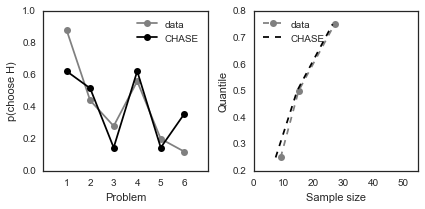

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID].values, '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')
#axi.set_xlim(0, mq[-1] + 2)
axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

In [17]:
from copy import deepcopy 
parset = deepcopy(bf_par[SIM_ID])

In [18]:
parset.update(F)

In [19]:
parset

{'minsamplesize': 2,
 'p_sample_H': 0.5,
 'p_stay': 0.79467007632699993,
 'pref_units': 'sums',
 'prelec_gamma': 1.3973844709600001,
 'stepsize': 0.2,
 'stoprule': 'optional',
 'tau': 0.65992823838399994,
 'theta': 1}

In [20]:
arr = []
for i in range(6):
    r = m(problems[i], parset)
    ess = np.array(r['exp_samplesize'])[0]
    for ss in ess:
        arr.append(ss)
arr = np.array(arr)

KeyError: 'probid'

In [32]:
chdf = data.groupby(['problem', 'choice']).apply(lambda d: d.samplesize.mean()).reset_index()
chdf.columns = ['problem', 'choice', 'mn_ss']
chdf['pred_mn_ss'] = arr

ValueError: Length of values does not match length of index

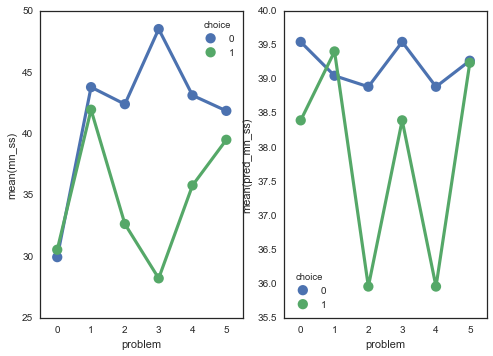

In [96]:
fig, ax = plt.subplots(1, 2)
sns.pointplot(x='problem', y='mn_ss', hue='choice', data=chdf, ax=ax[0])
sns.pointplot(x='problem', y='pred_mn_ss', hue='choice', data=chdf, ax=ax[1])
plt.show()

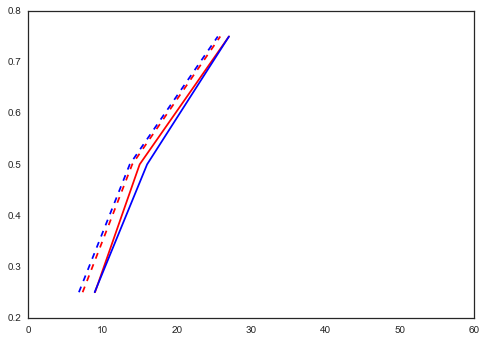

In [33]:
cols_L = ['ss_L(.25)','ss_L(.5)','ss_L(.75)']
cols_H = ['ss_H(.25)','ss_H(.5)','ss_H(.75)']
pred_ss_L = pred.groupby('problem').apply(lambda d: d[cols_L].mean()).reset_index()[cols_L].mean().values
pred_ss_H = pred.groupby('problem').apply(lambda d: d[cols_H].mean()).reset_index()[cols_H].mean().values

fig, ax = plt.subplots()
ax.plot(pred_ss_L, [.25, .5, .75], '--', color='red')
ax.plot(pred_ss_H, [.25, .5, .75],'--', color='blue')
ax.plot(mquantiles(data[data.choice==0].samplesize), [.25, .5, .75], '-', color='red')
ax.plot(mquantiles(data[data.choice==1].samplesize), [.25, .5, .75], '-', color='blue')
ax.set_xlim(0, 60)
plt.show()

# Combine results

In [23]:
studies = ['hertwig2004', 'hau_exp1', 'hau_exp2']
labels = ['HBWE04', 'HPKH08, Exp 1', 'HPKH08, Exp 2']
col = ['red', 'blue', 'purple']

def pars_to_latex(s):
    s = s.replace('|c=0.5,minsamplesize=2', '')
    s = s.replace(',tau,theta', '')
    s = s.replace('p_stay', '$\theta$, $p_{stay}$, $\tau$')
    s = s.replace('pow_gain', ' $\\alpha$')
    s = s.replace('prelec_gamma', ' $\\gamma$')
    s = s.replace('prelec_elevation', ' $\\delta$')
    s = s.replace('w_loss', ' $\\lambda$')
    return s


res = {}
for study in studies:
    res[study] = pd.read_csv('%s/%s_fitsummary.csv' % (TABDEST, study), index_col=0)

models = res[studies[0]].sim_id
summed_bic = [np.sum([res[r].loc[i].bic for r in res]) for i in range(len(models))]

arr = []
for i in range(len(models)):
    arr.append([res['hertwig2004'].loc[i].sim_id.lstrip('hertwig2004(').rstrip(')')] + \
               [np.round(res[r].loc[i].bic, 1) for r in studies] + \
               [np.round(np.sum([res[r].loc[i].bic for r in studies]), 1)])

bicdf = pd.DataFrame(arr, columns=['sim_id', 'bic_hertwig2004', 'bic_hau_exp1', 'bic_hau_exp2', 'bic_combined'])
bicdf.sort_values(by='bic_combined', inplace=True)
bicdf.to_csv('%s/bics_combined_6problems.csv' % TABDEST)
bicdf['sim_id'] = map(pars_to_latex, bicdf.sim_id.values)
bicdf.to_latex('%s/bics_combined_6problems.tex' % TABDEST)

In [24]:
bicdf

,sim_id,bic_hertwig2004,bic_hau_exp1,bic_hau_exp2,bic_combined
5,"$\theta$, $p_{stay}$, $\tau$, $\gamma$|minsamplesize=2,p_sample_H=0.5,pref_units=sums,stoprule=o...",1371.2,1910.3,2506.9,5788.5
3,"$\theta$, $p_{stay}$, $\tau$, $\alpha$|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=...",1379.2,1908.6,2504.6,5792.4
7,"$\theta$, $p_{stay}$, $\tau$, $\alpha$|minsamplesize=2,p_sample_H=0.5,pref_units=sums,stoprule=o...",1385.9,1909.0,2502.2,5797.0
6,"$\theta$, $p_{stay}$, $\tau$, $\delta$, $\gamma$|minsamplesize=2,p_sample_H=0.5,pref_units=sums,...",1376.1,1914.9,2506.0,5797.1
2,"$\theta$, $p_{stay}$, $\tau$, $\delta$, $\gamma$|minsamplesize=2,p_sample_H=0.5,pref_units=diffs...",1379.5,1914.7,2506.7,5800.9
11,"$\theta$, $p_{stay}$, $\tau$,p_stop, $\alpha$,tau|minsamplesize=2,p_sample_H=0.5,pref_units=diff...",1390.9,1910.9,2502.4,5804.2
14,"$\theta$, $p_{stay}$, $\tau$,p_stop, $\delta$, $\gamma$,tau|minsamplesize=2,p_sample_H=0.5,pref_...",1389.8,1932.1,2507.1,5828.9
1,"$\theta$, $p_{stay}$, $\tau$, $\gamma$|minsamplesize=2,p_sample_H=0.5,pref_units=diffs,stoprule=...",1379.8,1946.3,2517.4,5843.5
9,"$\theta$, $p_{stay}$, $\tau$,p_stop, $\gamma$,tau|minsamplesize=2,p_sample_H=0.5,pref_units=diff...",1396.2,1948.4,2510.7,5855.3
15,"$\theta$, $p_{stay}$, $\tau$,p_stop, $\alpha$,tau|minsamplesize=2,p_sample_H=0.5,pref_units=sums...",1394.1,1963.9,2511.5,5869.5


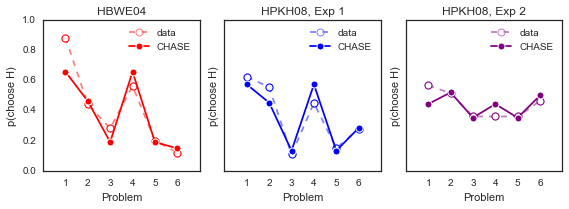

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
for i, study in enumerate(['hertwig2004', 'hau_exp1', 'hau_exp2']):
    axi = ax[i]
    axi.plot(range(1, 7), cp[study], '--o', markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, color=col[i], alpha=.5,
             label='data')

    # hacky
    axi.plot(range(1, 7), cp[study], 'o', markerfacecolor='white', markeredgecolor=col[i],
             markeredgewidth=1)


    axi.plot(range(1, 7), bf_cp[study], '-o', markerfacecolor=col[i], markeredgecolor='white', 
             markeredgewidth=1, color=col[i], label='CHASE')
    axi.set_ylim(0, 1)
    axi.set_xlim(0, 7)
    axi.set_xticks(range(1,7))
    axi.set_xlabel('Problem')
    axi.set_ylabel('p(choose H)')
    axi.set_title(labels[i])
    axi.legend()
plt.tight_layout()
plt.show()
fig.savefig('%s/6problems_choiceprop.pdf' % FIGDEST, bbox_inches='tight')

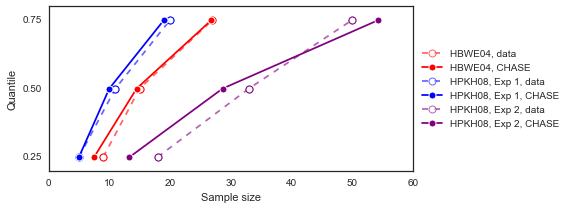

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

axi = ax
for i, study in enumerate(['hertwig2004', 'hau_exp1', 'hau_exp2']):

    axi.plot(quant[study], [.25, .5, .75], '--o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, label='%s, data' % labels[i], alpha=.6)
    
    # hacky
    axi.plot(quant[study], [.25, .5, .75], 'o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], markeredgewidth=1)

    axi.plot(bf_quant[study], [.25, .5, .75], '-o', color=col[i], 
             markerfacecolor=col[i], markeredgecolor='white',
             markeredgewidth=1, label='%s, CHASE' % labels[i])

axi.set_xlim(0, 60)
axi.legend(loc='center left', bbox_to_anchor=(1,.5))
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')
axi.set_yticks([.25, .5, .75])

plt.tight_layout()
plt.show()
fig.savefig('%s/6problems_quantiles.pdf' % FIGDEST, bbox_inches='tight')

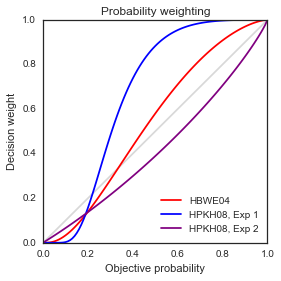

In [28]:
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)
for i, sim in enumerate(studies):
    delta = bf_par[sim]['prelec_elevation']
    gamma = bf_par[sim]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', label=labels[i], color=col[i])
axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
axi.legend(loc='lower right')
plt.tight_layout()
plt.show()
fig.savefig('%s/6problems_weighting.pdf' % FIGDEST, bbox_inches='tight')

In [29]:
bf_par

{'hau_exp1': {'p_stay': 0.92333321961899995,
  'prelec_elevation': 0.40287165908799999,
  'prelec_gamma': 3.2019775354000002,
  'tau': nan,
  'theta': 1},
 'hau_exp2': {'p_stay': 0.46330962427900002,
  'prelec_elevation': 1.303858065,
  'prelec_gamma': 0.880205374682,
  'tau': 0.66615972116900002,
  'theta': 5},
 'hertwig2004': {'p_stay': 0.35895100487099996,
  'prelec_elevation': 0.95295431956499999,
  'prelec_gamma': 1.52571445931,
  'tau': 0.64802866992700003,
  'theta': 4}}